In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


You are offering a commodity or asset for some price $x$ to customers. The customer decision to buy or not follows $Bern(p(x))$, where the probability of a buy $p(x)$ is a decreasing function of the price. Your expected revenue is $x p(x)$. You increase the price, does this affect the probability of a buy? If it does not, you have increased the revenue.

This is equivalent to comparing two coins if the probability of success has increased.

# 1. Test if coin bias has changed (small sample)

The below comparions are considering a positive change in $p$. However, due to symmetry, this can be easily applied to a decrease in $p$.

## 1.1. Naive method $P(\hat{p}_1 > \hat{p}_0)$

Let $X_i \sim Bin(n_i, p_i)$

with probability mass function denoted by $f(k; n_i, p_i)$.

Define the change in success rate $D =: p_1 - p_0$, which has MLE estimate

$\hat{D} = \hat{p}_1 - \hat{p}_0 = \frac{X_1}{n_1} - \frac{X_0}{n_0}$.

Then $P(\hat{D} > 0) = \sum \limits_{G} f(k_0, n_0, p_0)f(k_1, n_1, p_1)$, 

where $G = \{k_0, k_1 : \frac{k_1}{n_1} - \frac{k_0}{n_0} > 0 \}$.


Hence, the probability is a function of $p_0,p_1$, which we do not know.

Naively, we can replace $p_0,p_1$ with their MLE point estimates, yielding

$\widehat{P}(\hat{D} > 0) = \sum \limits_{G} f(k_0, n_0, \hat{p}_0)f(k_1, n_1, \hat{p}_1)$.

Note that this is a random quantity with respect to $\hat{p}_0$ and $\hat{p}_1$. Hence, the marginal distribution is given as a binomial with a binomial prior.

Taking expectations yields
\begin{align}
E[\widehat{P}(\hat{D} > 0)] &= \sum\limits_{p_0,p_1} P(\hat{D} > 0|p_0, p_1)P(p_0,p_1) \\
& = \sum\limits_{s_0,s_1} \sum \limits_{G} f(k_0, n_0,\frac{s_0}{n_0})f(s_0, n_0,p_0) \cdot f(k_1, n_1, \frac{s_1}{n_1})f(s_1, n_1,p_1)
\end{align}
which again is a function of the unknown nuance parameters $p_0,p_1$.

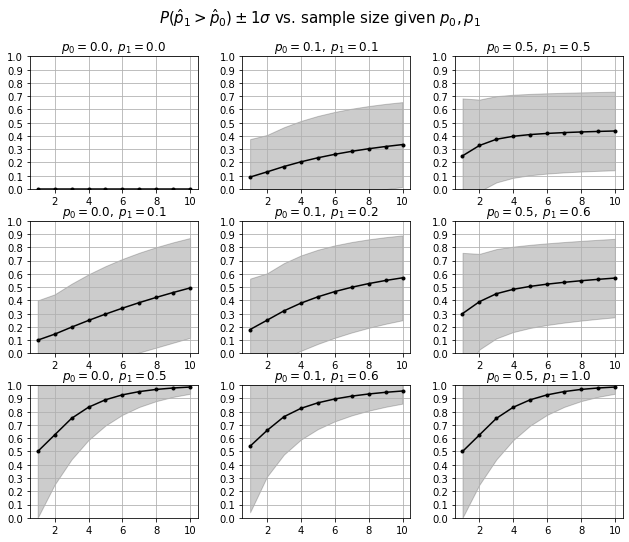

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.special import comb
np.seterr('raise')


def naive_exact(n:int, p0, theta): # Pr(Dhat > 0) = Sum Pr(D|p0,p1)*Pr(p0,p1)
    p1 = p0 + theta
    mom1 = 0 # 1st moment = mean
    mom2 = 0 # 2nd moment = var + mean^2
    for a0 in range(n+1):
        for a1 in range(n+1):
            q0 = a0 / n
            q1 = a1 / n
            prior_pmf = stats.binom.pmf(a0, n, p0)*stats.binom.pmf(a1, n, p1)
            pgeq = 0
            for k0 in range(n + 1):
                for k1 in range(n + 1):
                    if k1/n - k0/n > 0:
                        #epr += prior_pmf * stats.binom.pmf(k0, n, q0) * stats.binom.pmf(k1, n, q1)
                        pgeq += stats.binom.pmf(k0, n, q0) * stats.binom.pmf(k1, n, q1)
            mom1 += pgeq * prior_pmf
            mom2 += pgeq**2 * prior_pmf
    mean = mom1
    std = (mom2 - mom1**2)**0.5
    return mean, std

pp0 = [0.0, 0.1, 0.5]
thetas = [0.0, 0.1, 0.5]
n_max = 10
nn = np.arange(n_max) + 1

fig, axs = plt.subplots(3, 3, figsize=(9,7))
fig.suptitle('$P(\hat{p}_1 > \hat{p}_0) \pm 1\sigma$ vs. sample size given $p_0, p_1$', fontsize=15, y=1.07)
fig.tight_layout()

for row in range(len(thetas)):
    for col in range(len(pp0)):
        mean, std = zip(*[naive_exact(n, pp0[col], thetas[row]) for n in nn])
        mean = np.array(mean)
        std = np.array(std)
        #pgeq = np.array([naive_exact(n, pp0[col], thetas[row]) for n in nn])
        axs[row,col].plot(nn, mean, marker='.', color='k')
        axs[row,col].fill_between(nn, mean-std, mean+std, color='k', alpha=0.2)
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_yticks(np.arange(11)/10)
        axs[row,col].set_title('$p_0={}, \; p_1={}$'.format(pp0[col], pp0[col]+thetas[row]))
        axs[row,col].grid()
    
plt.show()

## 1.2. Bayesian posterior with uniform priors $P(\hat{p}_1 > \hat{p}_0)$

In the previous method, we used the MLE for finding the possible values of $p$. This method finds the binomial distirbusion that is most likely to have generated the data, i.e. the mode of the likelihood function. However, instead of using the most likely distribution, we can create a weighning of an infinite distributions with weights equal to the likelihood function. This is equivalent to finding the posterior distribution with a uniform prior.

For a single observation from a binomial we have that $\mathcal{L}(p|k) = f(k,n,p)$

Previously, we found that $\hat{p}= k/n$ is the estimator that maximizes $\mathcal{L}(p|k)$. Now instead we turn $\mathcal{L}(p|k)$ into a density function using a uniform prior for the binomial parameters.

$\hat{p}|x \sim P(p|x) = \frac{\mathcal{L}(p|x) P(p)}{P(x)} \sim Beta(x+1, n-x+1)$


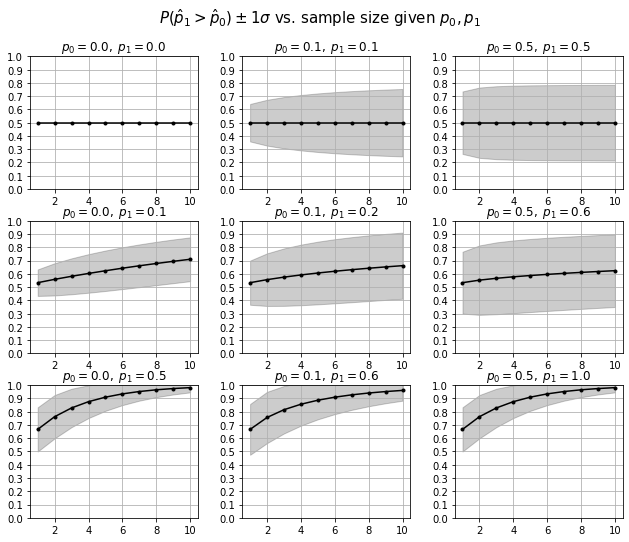

In [3]:
import scipy.special as special
from scipy.integrate import quad

def naive_bayes(n:int, p0, theta): # Pr(Dhat > 0) = Sum Pr(D|p0,p1)*Pr(p0,p1)
    p1 = p0 + theta
    mom1 = 0 # 1st moment = mean
    mom2 = 0 # 2nd moment = var + mean^2
    for a0 in range(n+1):
        for a1 in range(n+1):
            prior_pmf = stats.binom.pmf(a0, n, p0)*stats.binom.pmf(a1, n, p1)
            
            p0hd = stats.beta(a=a0+1, b=n-a0+1) # Posterior0
            p1hd = stats.beta(a=a1+1, b=n-a1+1) # Posterior1
            pgeq = quad(lambda p : p0hd.cdf(p)*p1hd.pdf(p), 0, 1)[0]
            
            mom1 += pgeq * prior_pmf
            mom2 += pgeq**2 * prior_pmf
    mean = mom1
    std = (mom2 - mom1**2)**0.5
    return mean, std


pp0 = [0.0, 0.1, 0.5]
thetas = [0.0, 0.1, 0.5]
n_max = 10
nn = np.arange(n_max) + 1

fig, axs = plt.subplots(3, 3, figsize=(9,7))
fig.suptitle('$P(\hat{p}_1 > \hat{p}_0) \pm 1\sigma$ vs. sample size given $p_0, p_1$', fontsize=15, y=1.07)
fig.tight_layout()

for row in range(len(thetas)):
    for col in range(len(pp0)):
        mean, std = zip(*[naive_bayes(n, pp0[col], thetas[row]) for n in nn])
        mean = np.array(mean)
        std = np.array(std)
        #pgeq = np.array([naive_exact(n, pp0[col], thetas[row]) for n in nn])
        axs[row,col].plot(nn, mean, marker='.', color='k')
        axs[row,col].fill_between(nn, mean-std, mean+std, color='k', alpha=0.2)
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_yticks(np.arange(11)/10)
        axs[row,col].set_title('$p_0={}, \; p_1={}$'.format(pp0[col], pp0[col]+thetas[row]))
        axs[row,col].grid()
    
plt.show()

## 1.2. Bayesian $P(\hat{p}_1 > \hat{p}_0)$

$prior_1 = posterior_0$ and  $prior_0=Beta(1,1)$

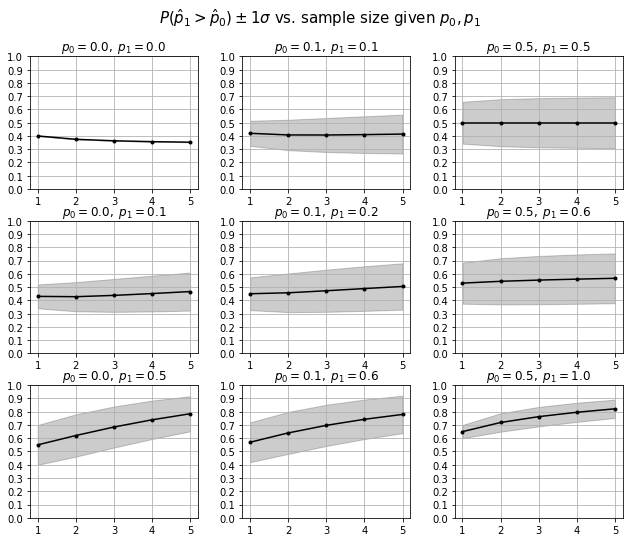

In [4]:
import scipy.special as special
from scipy.integrate import quad

def naive_bayes(n:int, p0, theta): # Pr(Dhat > 0) = Sum Pr(D|p0,p1)*Pr(p0,p1)
    p1 = p0 + theta
    mom1 = 0 # 1st moment = mean
    mom2 = 0 # 2nd moment = var + mean^2
    for a0 in range(n+1):
        for a1 in range(n+1):
            prior_pmf = stats.binom.pmf(a0, n, p0)*stats.binom.pmf(a1, n, p1)
            
            p0hd = stats.beta(a=a0+1, b=n-a0+1) # Posterior0
            p1hd = stats.beta(a=(a0+1) + a1, b=(n-a0+1) + n-a1) # Posterior1
            pgeq = quad(lambda p : p0hd.cdf(p)*p1hd.pdf(p), 0, 1)[0]
            
            mom1 += pgeq * prior_pmf
            mom2 += pgeq**2 * prior_pmf
    mean = mom1
    std = (mom2 - mom1**2)**0.5
    return mean, std


pp0 = [0.0, 0.1, 0.5]
thetas = [0.0, 0.1, 0.5]
n_max = 5
nn = np.arange(n_max) + 1

fig, axs = plt.subplots(3, 3, figsize=(9,7))
fig.suptitle('$P(\hat{p}_1 > \hat{p}_0) \pm 1\sigma$ vs. sample size given $p_0, p_1$', fontsize=15, y=1.07)
fig.tight_layout()

for row in range(len(thetas)):
    for col in range(len(pp0)):
        mean, std = zip(*[naive_bayes(n, pp0[col], thetas[row]) for n in nn])
        mean = np.array(mean)
        std = np.array(std)
        #pgeq = np.array([naive_exact(n, pp0[col], thetas[row]) for n in nn])
        axs[row,col].plot(nn, mean, marker='.', color='k')
        axs[row,col].fill_between(nn, mean-std, mean+std, color='k', alpha=0.2)
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_yticks(np.arange(11)/10)
        axs[row,col].set_title('$p_0={}, \; p_1={}$'.format(pp0[col], pp0[col]+thetas[row]))
        axs[row,col].grid()
    
plt.show()

## 1.2. Hypothesis Testing method

![title](hypotheses_probtree.png)

Given some data, we want to test if the data is coming from the model specified by H0, or if it is more likely to have come from an alternative model specified by H1.

The testing procedure we choose determines our probability of rejecting or accepting a model. We want to minimize the probability of making false conclusions, $\alpha:=P(\text{reject} \; \mathcal{H}_0|\mathcal{H}_0 \; \text{true})$ and $\beta:=P(\text{accept} \; \mathcal{H}_1|\mathcal{H}_1 \; \text{true})$. It is common to define $\text{Power}:=1-\beta = P(\text{reject} \; \mathcal{H}_0|\mathcal{H}_1 \; \text{true})$.

The parameter $\alpha$ is the significance level, and is often chosen to be small. Given a fixed $\alpha$, a good testing procedure yields high power. The power is an increasing function of $\alpha$ and sample size.

In classical frequentist binary hypothesis testing, having observed the data, and drawn a conclusion whether to reject or not, we can never conclude anything about the <u>probability</u> of $\mathcal{H}_0$ being true. We are only given certain guarantees in false conclusions in either case. To see why, the probability of $\mathcal{H}_0$ being true given that the testing rejected $\mathcal{H}_0$ in favor of $\mathcal{H}_1$ is given by Bayes theorem

$P(\mathcal{H}_0|\text{reject} \; \mathcal{H}_0) = \frac{ P(\text{reject} \; \mathcal{H}_0|\mathcal{H}_0)P(\mathcal{H}_0) }{P(\text{reject})} = \frac{\alpha P(\mathcal{H}_0) }{\alpha P(\mathcal{H}_0) + \text{PWR} \cdot P(\mathcal{H}_1)}$

Hence, we need to know the _prior probabilities_ $P(\mathcal{H}_0)$ and $P(\mathcal{H}_1)$, which are unknown to us. We need to decide on these a priori in order to draw any conclusions. If we have no belief that one hypothesis is more likely than the other, then we can set $P(\mathcal{H}_0)=P(\mathcal{H}_1)=0.5$, which will result in

$P(\mathcal{H}_0|\text{reject} \; \mathcal{H}_0) = \left(1+\frac{\text{PWR}}{\alpha}\right)^{-1}$

$P(\mathcal{H}_0|\text{accept} \; \mathcal{H}_0) = \left(1+\frac{1-\text{PWR}}{1-\alpha}\right)^{-1}$

### 1.2.1. Frequentism

$X_i \sim Bin(n_i,p_i)$

Consider the change in success rate $D = p_1 - p_2$ and we want to test

\begin{align}
\mathcal{H}_0:& \; D = 0 \\
\mathcal{H}_1:& \; D > 0
\end{align}

This is also known as a single sided test for a difference in proportions.

We reject the null hypothesis in favor of the alternative hypothesis when the observation $\hat{D}$ is larger than some critical value $c$. The critical value is chosen such that the number of false rejections under $\mathcal{H}_0$ is upper bounded by significance level $\alpha$, i.e. $P(\hat{D} \geq c |\mathcal{H}_0) \leq \alpha$. Using this same critical value under a specific $\mathcal{H}_1$, the number of true rejections, i.e. test power, is given by $Power = P(\hat{D} \geq c |\mathcal{H}_1)$.

Note that in the frequentist approach, we have conditioned on a hypothesis being true. That is, have no probability of either hypothesis occuring.


#### 1.2.1.1 Distribution of $\hat{D}$

The problem we face is that the distribution of $\hat{D}$ depends on the true parameters $p_0, p_1$.
We cannot easily create a test statistic that is invariant to these parameters.

Note that since
\begin{align}
E[\hat{D}|\mathcal{H}_0] &= 0 \\
V[\hat{D}|\mathcal{H}_0] &= p_0(1-p_0)\left(\frac{1}{n_0} + \frac{1}{n_1}\right)
\end{align}
we could normalize $\hat{D}$ with the standard deviation, if we knew $p_0$. We could estimate it but would still not be able to make the final distribution invariant to the true parameters. For large sample sizes, the distribution becomes less discrete in nature, and $\hat{D}$ normalized by the standard deviation given above is approximately invariant to the true parameters.

In the literature, many small sample tests have been proposed to handle these unknown true parameters. Examples of them are Fisher's exact test, which avoid the parameters by conditioning on the observed success margins, and Barnard's test which does a maximization over full parameter space. By construction, Barnard's test is more powerful than Fisher's test, and is often recommended. 

Our main issue is that since the support for $\hat{D}$ is discrete, the support for $\alpha$ is also discrete. Therefore, in practise, one choses an arbitrary significance level, let's say 0.1, such that the test size (actual significance level) is bounded by 0.1. Hence, the test size will depend on the sample size.

Since we are interested in comparing the test power for different sample sizes, we would like to fix the test size across sample sizes.

In order to exactly hit the significance level chosen, we can treat the critical value as stochatic, and extend the domain of $\alpha$ to the reals. We are  interpolating linearly in the distribution function between neighbouring values in its support.

Due to the difficulty in enforcing the test size for Barnard's test, we apply the modification to Fisher's Exact test, and conveniently name this new test the Modified Fisher's Exact test.


#### 1.2.1.2. Modified Fisher's Exact Test
Under the $\mathcal{H}_0$, we condition on the observed success margins
$f(x_1; K) := f(x_0, x_1 | x_0 + x_1 = K) = {K\choose x_1} {n_0+n_1-K\choose n_1-x_1}/{n_0+n_1\choose n_1}$,
which is a hypergeometric distribution, that does not depend on the success rates. The idea is that this is a proxy for the true density.

That is, given observation $K=x_0+x_1$, then $P(X_1 \geq c |\mathcal{H}_0, K) \leq \alpha$.

In order to exactly hit the significance level chosen, we can treat the critical value as stochatic, and extend the domain of $\alpha$ to the reals. We accomplish this by interpolating linearly in the distribution function between neighbouring values in its support.

 1. Pick some significance level $\alpha$.
 2. Find closest neighbouring significance levels that are attaintable and find the corresponding values $c_L$ and $c_R$. More formally, $c_L = sup\{x \in \Omega_D : P(\hat{D} \geq x | \mathcal{H}_0) \leq \alpha \}$, and $c_R = inf\{x \in \Omega_D : P(\hat{D} \geq x | \mathcal{H}_0) < \alpha \}$.
 3. In case $c_R$ does not exist, we set $c_R$ to a value larger than the largest value in the support, such that $P(\hat{D} \geq c_R) = 0$. This implies that $P(\hat{D} \geq c_L) = 1$.
 4. Let the stochastic cut-off bound be $c := Z c_{\text{L}} + (1-Z) c_{\text{R}}$, where $Z \sim Bernoulli(p)$.
 5. $\alpha = P(\hat{D} \geq c) = P(\hat{D} \geq c_{\text{L}}) \cdot p + P(\hat{D} \geq c_{\text{R}}) \cdot (1-p) $ $\;\; \Longrightarrow \;\; p = \frac{F(c_L) - (1-\alpha)}{f(c_L)}$.
 6. Given an observation $d$, accept $\mathcal{H}_0$ if $d < c_L$, and with probability $p$ if $d\equiv c_L$. Reject $\mathcal{H}_0$ if $d\geq c_R$.
 7. We can write $P(\text{Reject} \; \mathcal{H}_0 | d) = min\left(1, max\left(0, \frac{F(d)-(1-\alpha)}{f(d)}\right)\right)$.
 
We have now a guarantee that the test size equals $\alpha$ for any sample size, when we compare the power of the test across samples sizes.


#### 1.2.1.3. a priori Power analysis of the Modified Fisher's Exact Test

To perform a power anlysis, we must pick a specific pair {$\mathcal{H}_0$, $\mathcal{H}_1$}. That is, we need to choose $p_0, p_1$, such that $\theta := p_1-p_0$. The bigger the difference between them, the higher the power (smaller sample size needed). Notice that in order to detect an infinitesimal change in the sucess rate, it would require an infinite sample size. 

Furthermore, we assume that the sample size is equal for the two binomials. This ease the visualization and lead to simple calculations for the lower and upper bounds for the power.


Maximum power is given when entropy of the bivariate binomial is minimized, i.e. $p_0=0$ (or $p_0 = 1-\theta$ by symmetry). Minimum power is reached when entropy of the bivariate binomial distribution is maximized, that is $p_0=(1-\theta)/2$.

Hence, for various values of the test size $\alpha$ and success rate change $\theta$, we plot the sample size as a function of the test power.

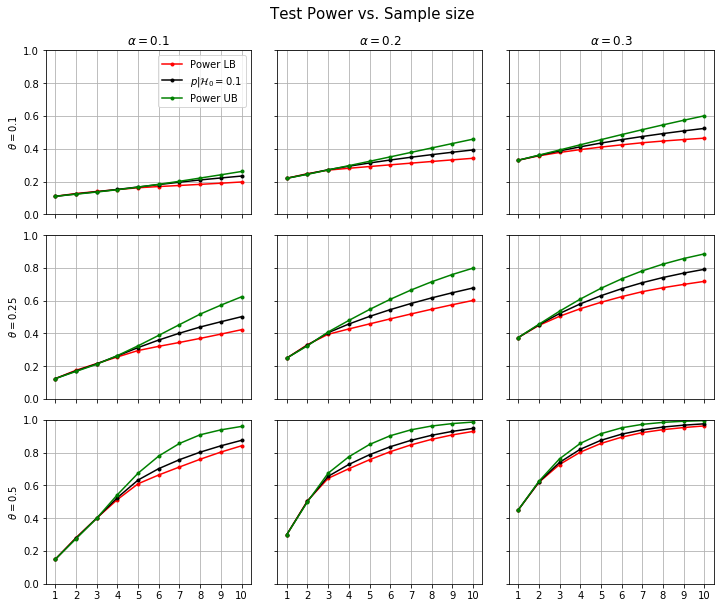

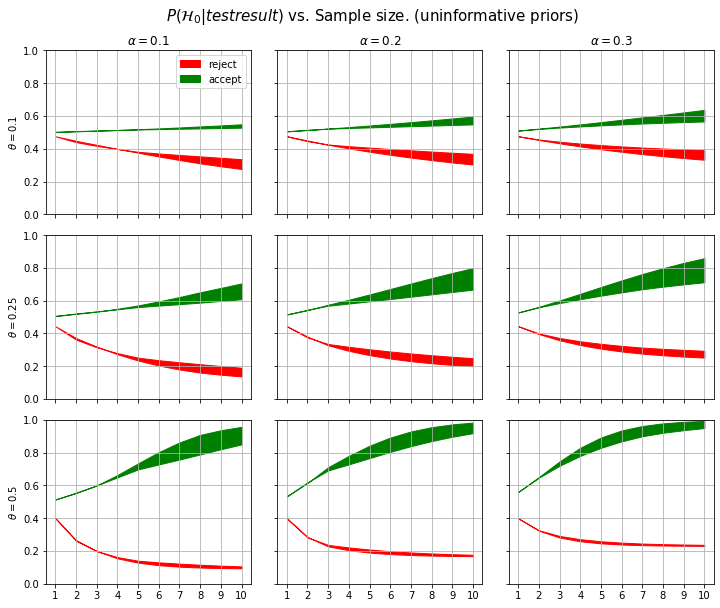

In [5]:

class Hypothesis:
    def __init__(self, pH0, theta):
        self.pH0 = pH0
        self.pH1 = pH0 + theta
        
def fisher_test_manual(x0, n0, x1, n1, alpha):
    cont_table = [[x0, x1], [n0-x0, n1-x1]]
    hg = stats.hypergeom(M=n0+n1, n=x0+x1, N=n1)
    pgeq = sum(hg.pmf(k) for k in range(x1, n1+1))    
    tmp = (alpha - (pgeq - hg.pmf(x1))) / hg.pmf(x1)
    rej = min(max(0, tmp), 1)
    return rej

def run(alpha, theta, n_max=10):
    test_LB = Hypothesis(pH0=0.5-theta/2, theta=theta)
    test_cust = Hypothesis(pH0=0.1, theta=theta)
    test_UB = Hypothesis(pH0=1-theta, theta=theta)

    tests = [test_LB, test_cust, test_UB]

    nn = np.arange(n_max) + 1
    rfish = np.zeros((3, n_max))
    for ni in range(len(nn)):
        n = nn[ni]
        for itest in range(len(tests)):
            for k0 in range(n+1):
                for k1 in range(n+1):
                    expect_rej = fisher_test_manual(k0, n, k1, n, alpha)
                    pr_state = stats.binom.pmf(k0, n, tests[itest].pH0) * stats.binom.pmf(k1, n, tests[itest].pH1)
                    rfish[itest, ni] += expect_rej * pr_state
    return rfish


alpha = [0.1, 0.2, 0.3]
theta = [0.1, 0.25, 0.5]

PrH0Rej = lambda a, pwr : (1 + pwr/a)**(-1) # Priors P(H0)=P(H1)=0.5
PrH0Acc = lambda a, pwr : (1 + (1-pwr)/(1-a))**(-1) # Priors P(H0)=P(H1)=0.5

fig, axs = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
fig.suptitle('Test Power vs. Sample size', fontsize=15, y=1.05)
fig.tight_layout()

fig2, axs2 = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
fig2.suptitle('$P(\mathcal{H}_0|test result)$ vs. Sample size. (uninformative priors)', fontsize=15, y=1.05)
fig2.tight_layout()

n_max = 10
nn = np.arange(n_max) + 1
for col in range(len(alpha)):
    for row in range(len(theta)):
        np.random.seed(0)
        res = run(alpha=alpha[col], theta=theta[row], n_max=n_max)
        axs[row,col].plot(nn, res[0], marker='.', color='r', label='Power LB') # custom
        axs[row,col].plot(nn, res[1], marker='.', color='k', label='$p|\mathcal{H}_0=0.1$') # 
        axs[row,col].plot(nn, res[2], marker='.', color='g', label='Power UB') # around 0.5
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_xticks(np.arange(n_max)+1)
        axs[row,col].grid()
        
        
        axs2[row,col].fill_between(nn, PrH0Rej(alpha[col], res[0]), PrH0Rej(alpha[col], res[2]), color='r', alpha=1.0, label='reject')
        axs2[row,col].fill_between(nn, PrH0Acc(alpha[col], res[0]), PrH0Acc(alpha[col], res[2]), color='g', alpha=1.0, label='accept')
        axs2[row,col].set_ylim([0, 1.0])
        axs2[row,col].set_xticks(np.arange(n_max)+1)
        axs2[row,col].grid()        


        
for i in range(axs.shape[0]):
    axs[i,0].set_ylabel('$\\theta={}$'.format(theta[i]))
    axs2[i,0].set_ylabel('$\\theta={}$'.format(theta[i]))
for i in range(axs.shape[1]):
    axs[0,i].set_title('$\\alpha={}$'.format(alpha[i]))
    axs2[0,i].set_title('$\\alpha={}$'.format(alpha[i]))
    
axs[0,0].legend()
axs2[0,0].legend()
plt.show()

E.g. if allow a false positive rate of 20% ($\alpha=0.2$), and want a true positive rate of minimum 60% to detect a change of 25% points or more, we require 6 samples in the best case (power UB) and 10 samples in the worst case (power LB).

Alternatively, if we specify the priors $P(\mathcal{H}_0) = P(\mathcal{H}_1) = 0.5$, we can map the power to the probability of the null hypothesis being true, given the test result. Hence, with 6 samples, if the test cannot reject $\mathcal{H}_0$, the probability is 60%-67% that the null hyopthesis is true, whereas if the test rejects $\mathcal{H}_0$, the probability is 25%-30% that $\mathcal{H}_0$ is true. 

### 1.2.2. Bayesianism


TODO: Hypothesis testing with beta priors

TODO: expected loss (expected change in p) instead of binary testing


# 2. Point estimation of N ordered binomials.

Given $N$ ordered coins, and for each coin $i=1,...,N$ some trials $X_i \sim Bin(n_i, p_i)$. The coins are ordered in the sense that it is known a priori that the success rates are monotonically increasing, i.e. given the event $\mathcal{M}:p_1 \leq p_2 \leq ... \leq p_N$.

### 2.1. Conditional MLE

If $f$ is the binomial pmf, then the pmf conditional on $\pmb{p}\in \mathcal{M}$  is given by

$f_{\pmb{X}|\pmb{X} \in \mathcal{M}}(\pmb{k}, \pmb{p}) = \frac{f_{\pmb{X}}(\pmb{k}, \pmb{p}) \cdot \pmb{1}(\pmb{X} \in \mathcal{M})}{P(\pmb{X} \in \mathcal{M})}  \propto  f_{\pmb{X}}(\pmb{k}, \pmb{p}) \cdot \pmb{1}(\pmb{X} \in \mathcal{M})$

Hence, we can find the MLE estimate for the conditional density as
$\pmb{\hat{p}} = argmax_{\pmb{p}} \hat{L}(\pmb{p}|\pmb{n},\pmb{x})$ s.t. $\pmb{p} \in \mathcal{M}$

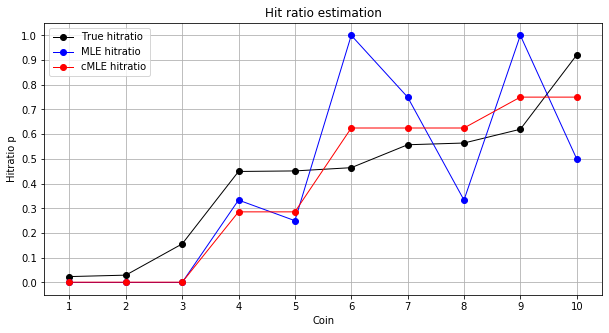

In [6]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import coinest as coins
%matplotlib inline

import warnings
from scipy.optimize import minimize, LinearConstraint
import scipy.stats as stats
def cmle_loglike(p, nvec, kvec):
    loglike = 0
    for i in range(p.shape[0]):
        loglike += -np.log(stats.binom.pmf(kvec[i], nvec[i], p[i]))
    return loglike

def cmle_est(ntrials, nsucc):
    ''' Conditional MLE argmax f(p|n,x) s.t. p monotonically incr parameters. '''
    ncoins = ntrials.shape[0]
    constraints = {'type':'ineq', 'fun':lambda x : np.diff(x)} # np.diff(x) > 0 constraint
    bounds = [(0.001, 0.999)] * ncoins
    x0 = [i/(ncoins+1) for i in range(ncoins)]
    res = minimize(cmle_loglike, x0, args=(ntrials, nsucc), bounds=bounds, constraints=constraints)
    if not res.success:
        warnings.warn(res.message, RuntimeWarning)
    return res.x

def mle_est(ntrials, ksucc):
    ''' MLE argmax f(p|n,x) '''
    return ksucc / ntrials

def sample_true_p(ncoins, dist):
    return np.sort(dist.rvs(ncoins))

def get_sample_data(ncoins):
    # Use beta as conjugate prior. Uniform: alpha=beta=1. Highly biased symmetric alpha=beta close to 0.
    alpha = beta = 1.0
    dist = stats.beta(alpha, beta)

    p_true = coins.sample_true_p(ncoins, dist)
    assert (np.diff(p_true)>=0).all(), "p_true is not monotonically increasing"

    # Simulate some #trials.
    ntrials = np.random.randint(1, 5, size=ncoins)

    # Simulate successes.
    X = np.random.binomial(ntrials, p_true, size=ncoins)
    
    return p_true, ntrials, X


if 1:
    # === Generate some sample data ===
    p_true, ntrials, X = get_sample_data(ncoins = 10)
else:
    ntrials = np.array([5, 6, 4])
    X = np.array([1, 4, 2])
    try: del p_true
    except: pass

# Estimation
p_hat_mle = coins.mle_est(ntrials, X)
p_hat_cmle = coins.cmle_est(ntrials, X)

# Plot
plt.figure(figsize=(10,5))
plt.title('Hit ratio estimation'); plt.xlabel('Coin'); plt.ylabel('Hitratio p')
xx = np.arange(ntrials.shape[0]) + 1
if 'p_true' in locals():
    plt.plot(xx, p_true, color='k', marker='o', linewidth=1.0, label='True hitratio')
plt.plot(xx, p_hat_mle, color='b', marker='o', linewidth=1.0, label='MLE hitratio')
plt.plot(xx, p_hat_cmle, color='r', marker='o', linewidth=1.0, label='cMLE hitratio')
plt.xticks(xx); plt.yticks(np.arange(11)/10)
plt.grid(); plt.legend()
plt.show()

The black line represent the true success rates (hit ratios) for each coin. The blue line is the result of naive MLE, which does not take into account the a priori information that success rates are monotonically increasing. The red line represent a conditional MLE, i.e. an MLE performed over the monotonic parameter space.